In [208]:
from pathlib import Path

import pandas as pd
import numpy as np
np.random.seed(42)
# from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [209]:
data = pd.read_parquet(Path('data/game_stats.parquet'))
X = data.iloc[:,6:-2]
anomaly_features = ['comp_rate_diff', 'block_turnover_diff']

## Outlier Detection
 - fit to (2) features for easy plotting. evaluate various thresholds and normalization methods.
   - best two engineered features `['comp_rate_diff', 'block_turnover_diff']`
   - PCA reduction
 - [graphical results](https://github.com/NBPub/Springboard/tree/main/Capstone%20Two/graphs/EDA/Outlier%20Detection)
   - **<font color="green">Inliers</font>**
     - **<font color="grey">tenth percentile of inliers</font>** marked to give a sense of a "border"
   - **<font color="pink">Outliers</font>**

---
 - **Isolation Forest**
   - `decision_function` provides score. `<0` outlier, `>0` not.
   - `predict` provides binary result. `-1` outlier, `1` not.
 - **Local Outlier Factor**
   - `<lof>.negative_outlier_factor_` provides score, more negative values are outliers
   - `<lof>.offset_` provides outlier threshold, points with scores lower than this are outliers
     - if threshold is not "auto", fits points such that specified percentage are considered outliers
 
*Known issue with fitting [Isolation Forest](https://github.com/scikit-learn/scikit-learn/issues/25844) with this version of scikit-learn, warnings can be ignored*

In [ ]:
anomaly_features = ['comp_rate_diff', 'block_turnover_diff']

### Isolation Forest - engineered features

In [61]:
anomaly_features = ['comp_rate_diff', 'block_turnover_diff']

In [63]:
import warnings
warnings.filterwarnings("ignore")

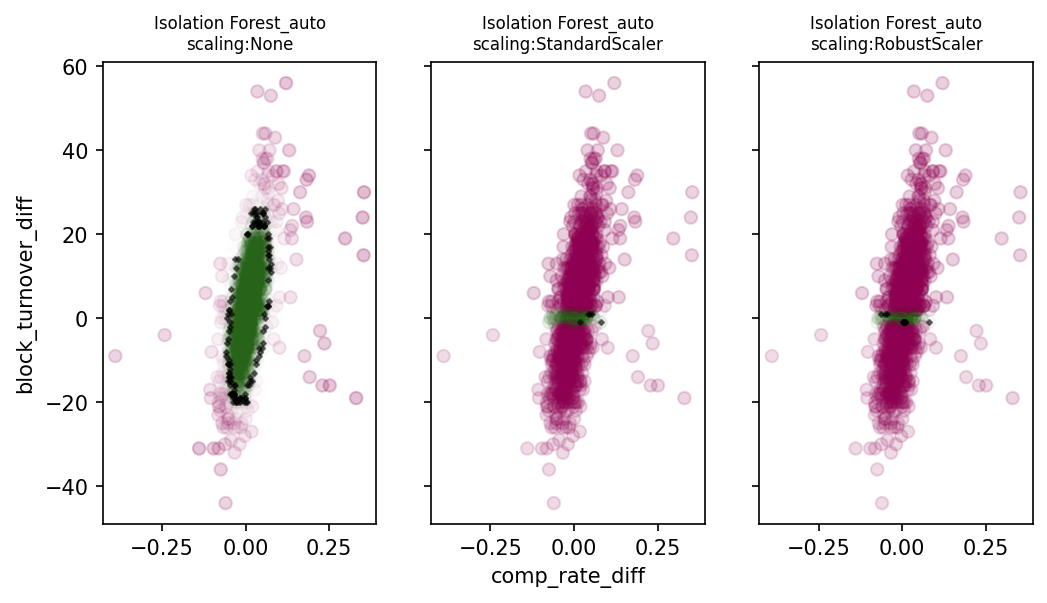

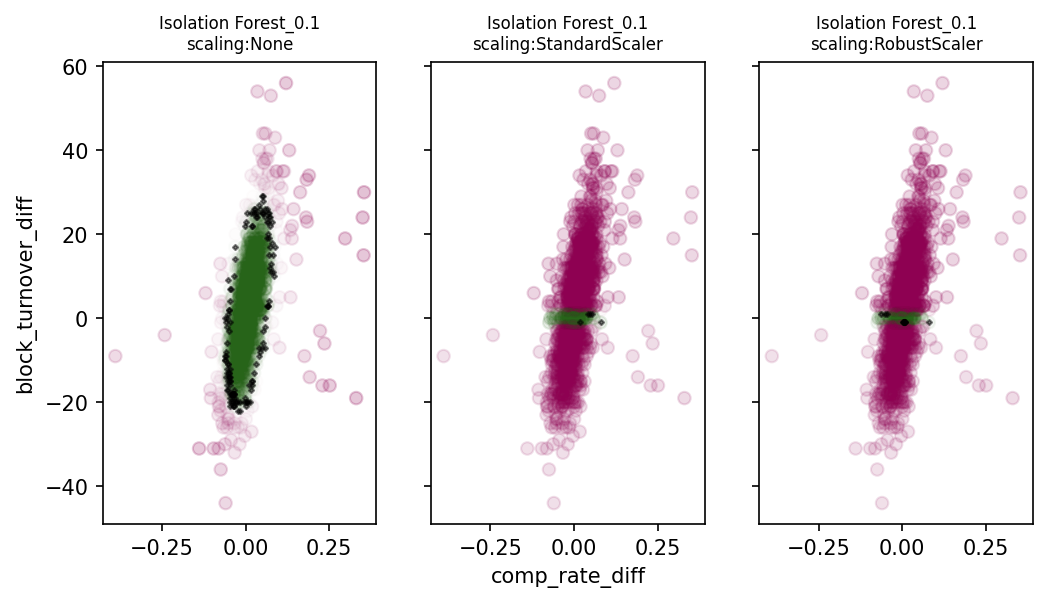

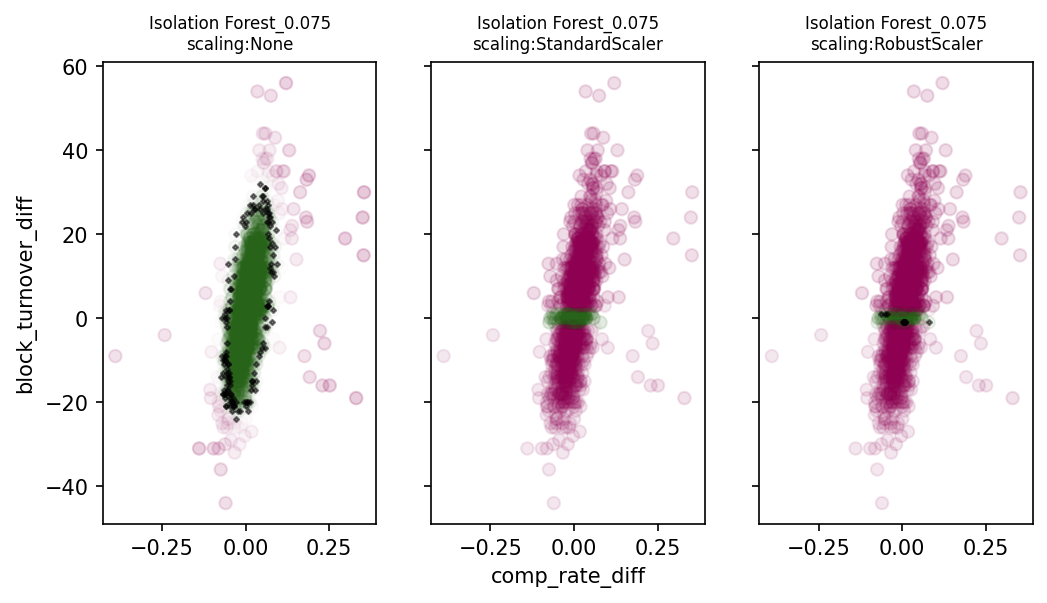

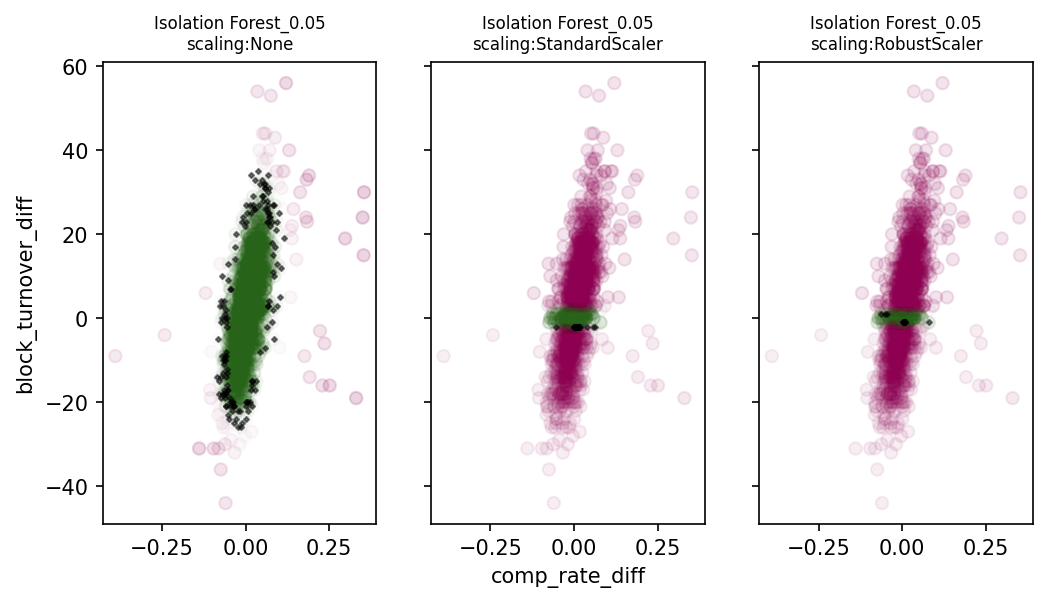

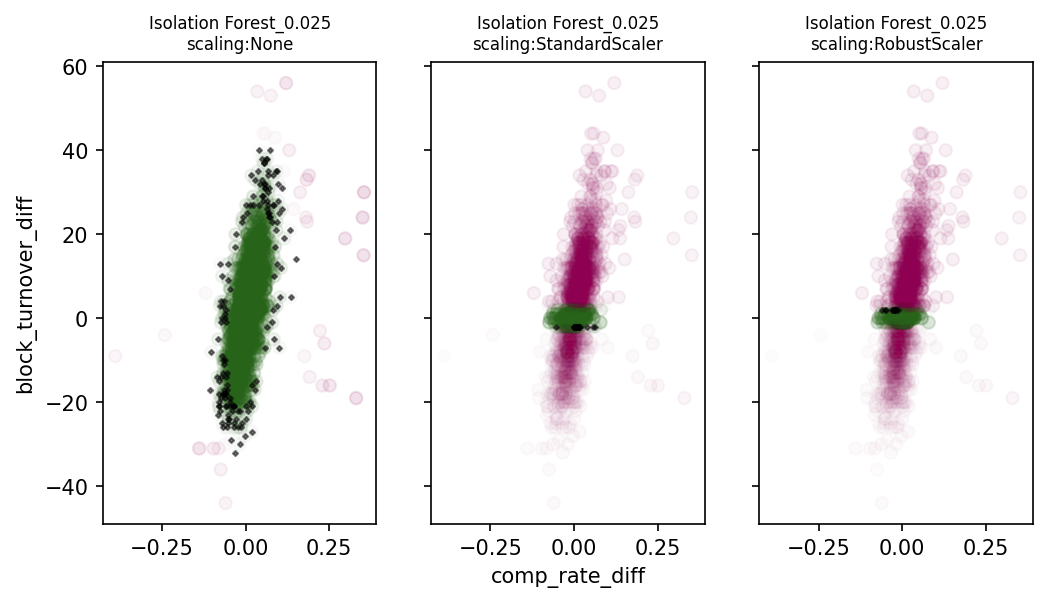

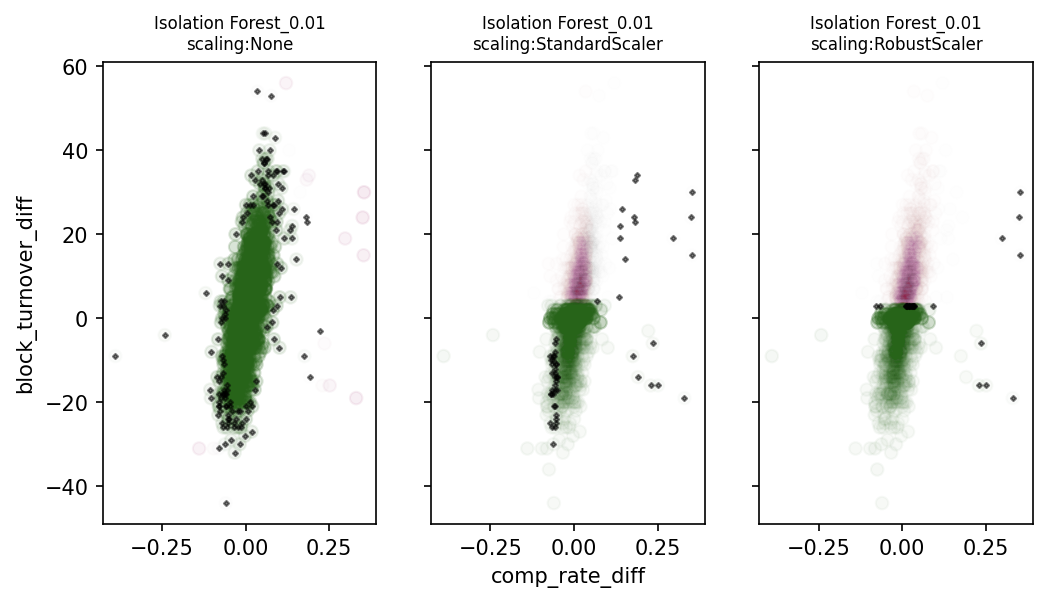

In [183]:
X = pd.DataFrame(data[anomaly_features])

for threshold in ['auto', 0.1, 0.075, 0.05, 0.025, 0.01]:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(8,4), dpi=150)
    iso_forest = IsolationForest(contamination=threshold, random_state=42)
    
    
    for cond in [(None, ax1), (StandardScaler(), ax2), (RobustScaler(), ax3)]:
        plot_data = X.copy()
        if cond[0]:
            iso_forest.fit(cond[0].fit_transform(plot_data))
        else:
            iso_forest.fit(plot_data)
        plot_data['anomaly_score'] = iso_forest.decision_function(plot_data)
        plot_data['outlier'] = iso_forest.predict(plot_data[anomaly_features])

        cond[1].scatter(plot_data[anomaly_features[0]], plot_data[anomaly_features[1]], 
                        c=plot_data['outlier'], cmap='PiYG',
                        alpha=abs(plot_data['anomaly_score']))   
        
        border = plot_data[
   (plot_data['outlier']==1) &\
   (plot_data['anomaly_score'] < np.percentile(plot_data[plot_data['outlier']==1]['anomaly_score'], 10))
                          ]

        cond[1].scatter(border[anomaly_features[0]], border[anomaly_features[1]], 
            marker='D', color='k', s=3, alpha=0.5) 
        
        cond[1].set_title(f'Isolation Forest_{threshold}\nscaling:{str(cond[0]).replace("()","")}',
                         fontsize=8)
        if cond[1] == ax1:
            cond[1].set_ylabel(anomaly_features[1])
        elif cond[1] == ax2:
            cond[1].set_xlabel(anomaly_features[0])
        
    plt.savefig(f'graphs/Outlier Detection/IsoForest_{threshold}.png', bbox_inches='tight')
    plt.show()

### Local Outlier Factor - engineered features

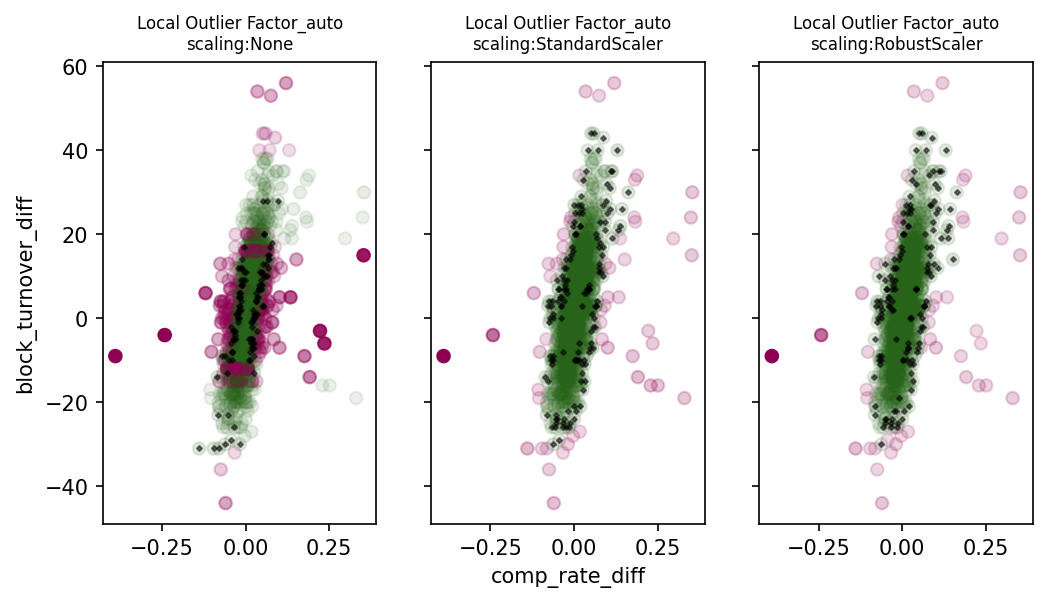

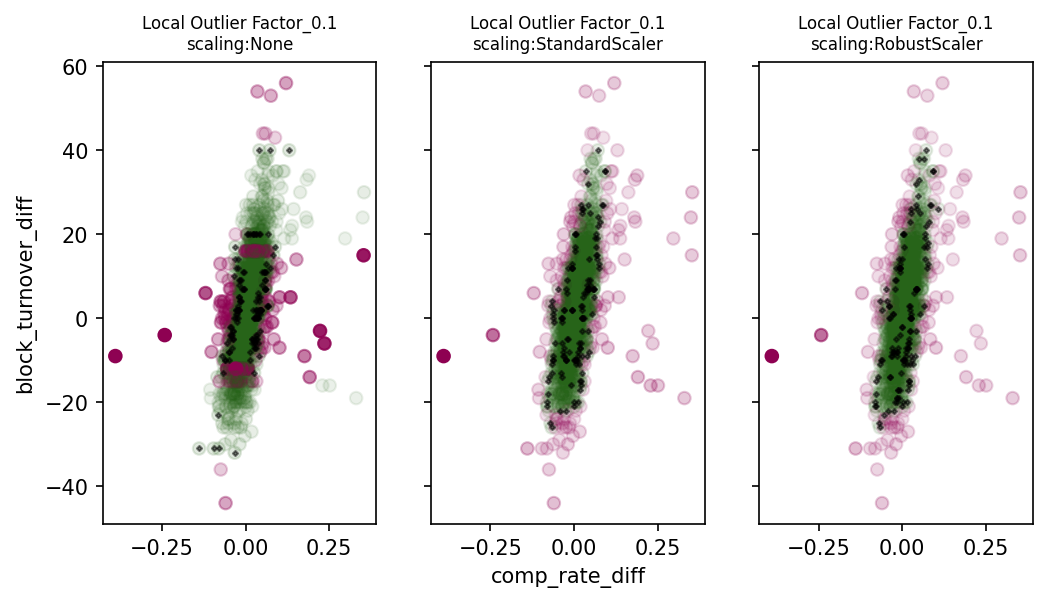

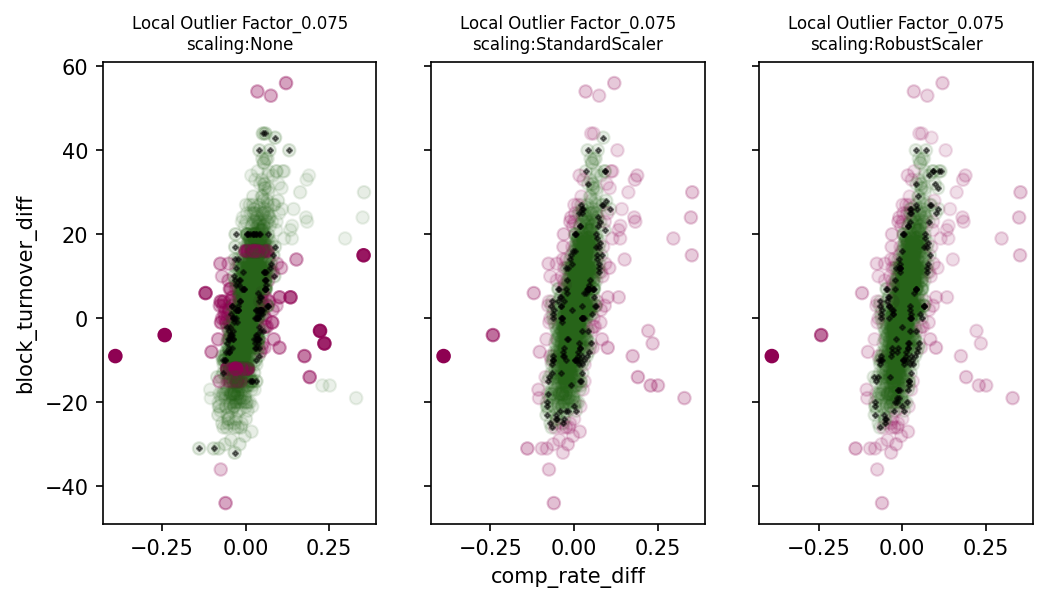

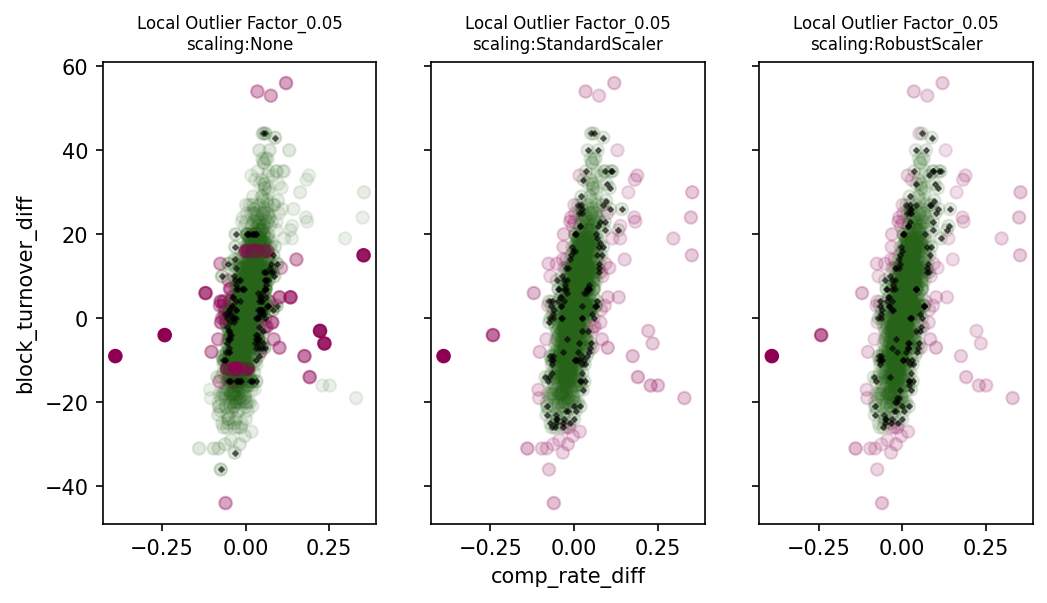

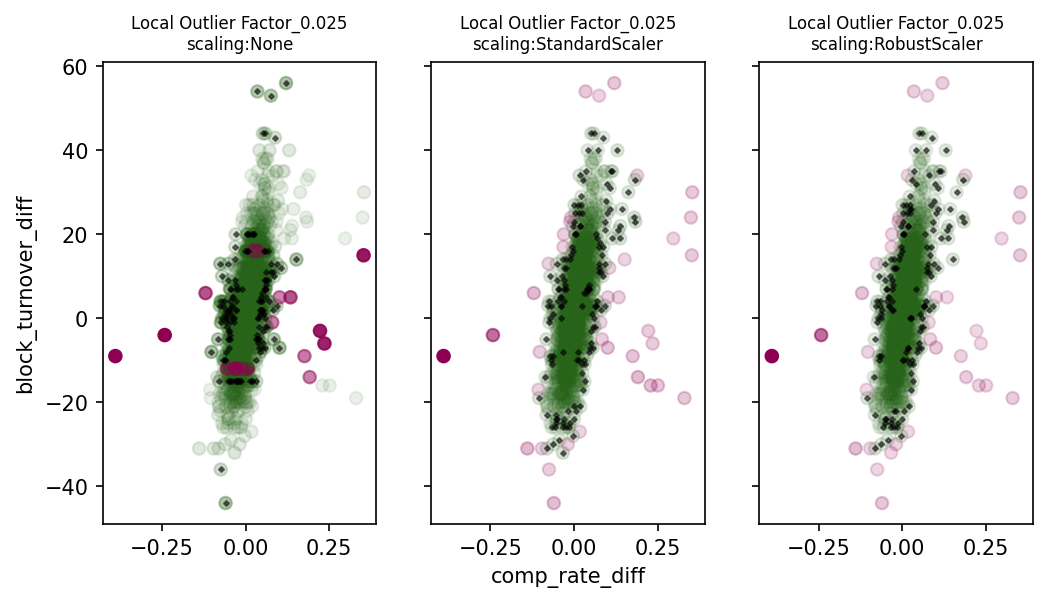

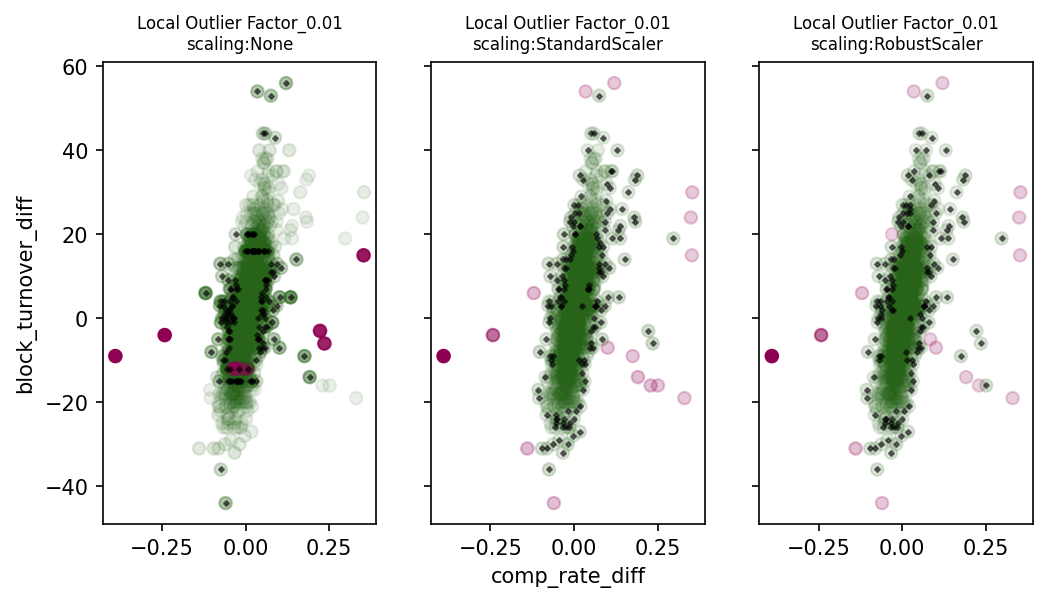

In [185]:
anomaly_features = ['comp_rate_diff', 'block_turnover_diff']
X = pd.DataFrame(data[anomaly_features])

for threshold in ['auto', 0.1, 0.075, 0.05, 0.025, 0.01]:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(8,4), dpi=150)
    lof = LocalOutlierFactor(contamination=threshold, novelty=False)
    
    
    for cond in [(None, ax1), (StandardScaler(), ax2), (RobustScaler(), ax3)]:
        plot_data = X.copy()
        if cond[0]:
            lof.fit(cond[0].fit_transform(plot_data))
        else:
            lof.fit(plot_data)
        plot_data['anomaly_score'] = lof.negative_outlier_factor_
        plot_data['outlier'] = plot_data['anomaly_score'] < lof.offset_

        cond[1].scatter(plot_data[anomaly_features[0]], plot_data[anomaly_features[1]], 
                        c=plot_data['outlier'], cmap='PiYG_r',
                        alpha=(1/abs(plot_data['anomaly_score']).max())*abs(plot_data['anomaly_score']))   
        
        border = plot_data[
   (plot_data['outlier']==0) &\
   (plot_data['anomaly_score'] < np.percentile(plot_data[plot_data['outlier']==0]['anomaly_score'], 10))
                          ]

        cond[1].scatter(border[anomaly_features[0]], border[anomaly_features[1]], 
            marker='D', color='k', s=3, alpha=0.5) 
        
        cond[1].set_title(f'Local Outlier Factor_{threshold}\nscaling:{str(cond[0]).replace("()","")}',
                         fontsize=8)
        if cond[1] == ax1:
            cond[1].set_ylabel(anomaly_features[1])
        elif cond[1] == ax2:
            cond[1].set_xlabel(anomaly_features[0])
        
    plt.savefig(f'graphs/Outlier Detection/LocalOutlierFactor_{threshold}.png', bbox_inches='tight')
    plt.show()

### Isolation Forest - PCA components

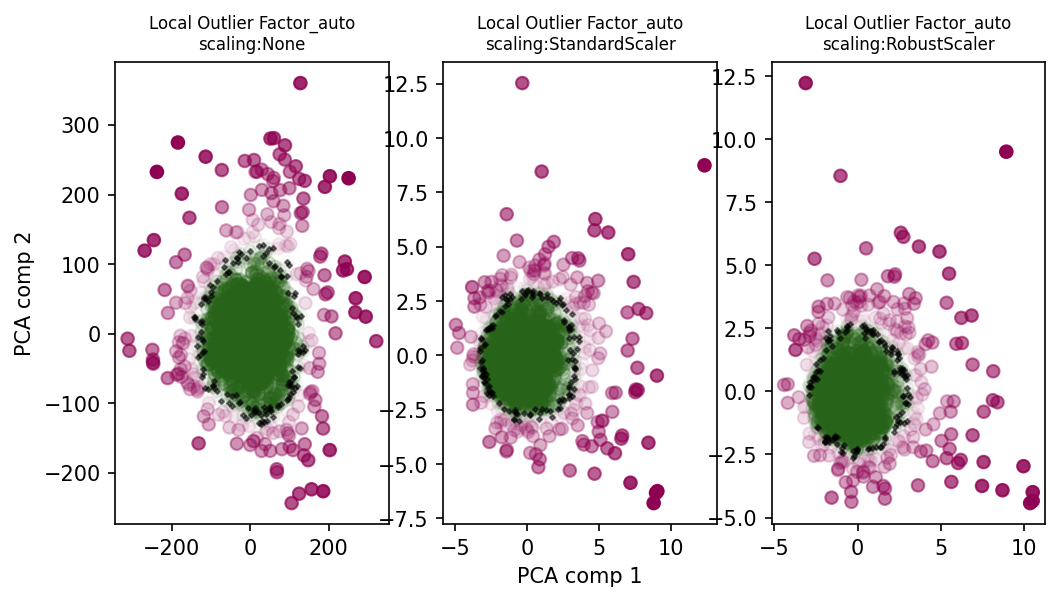

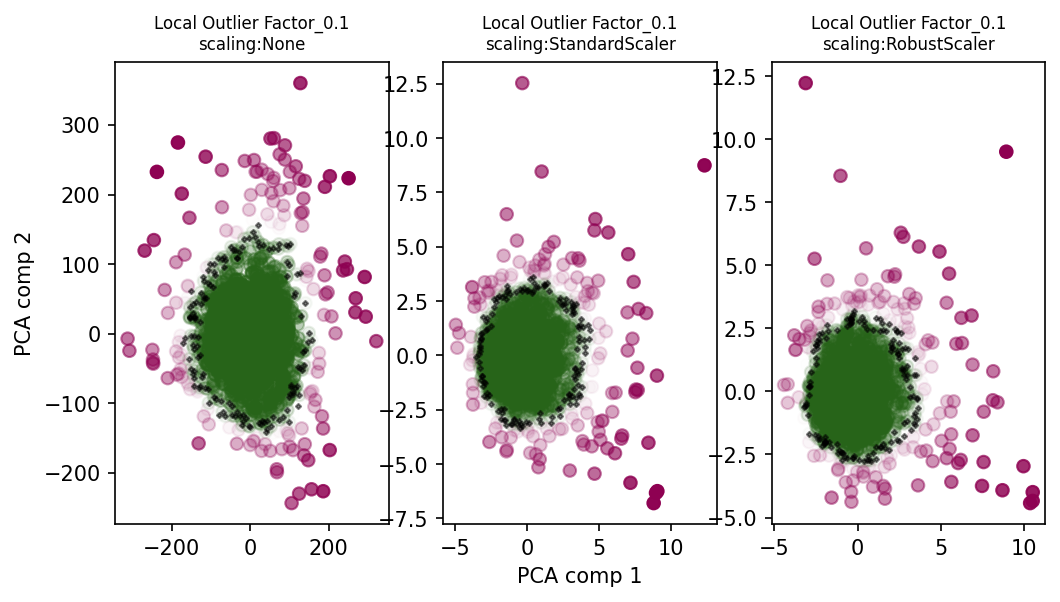

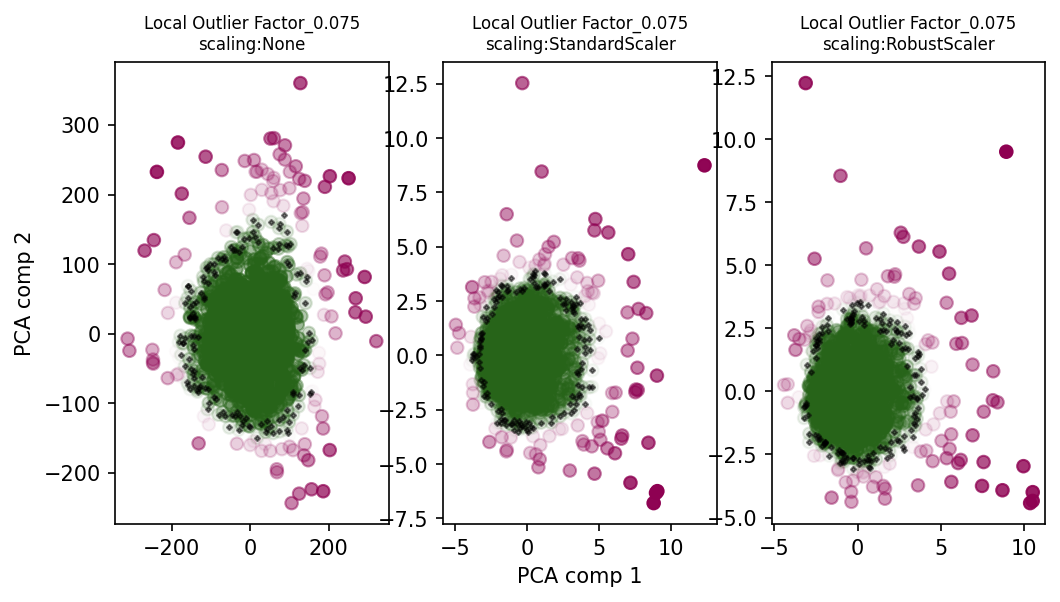

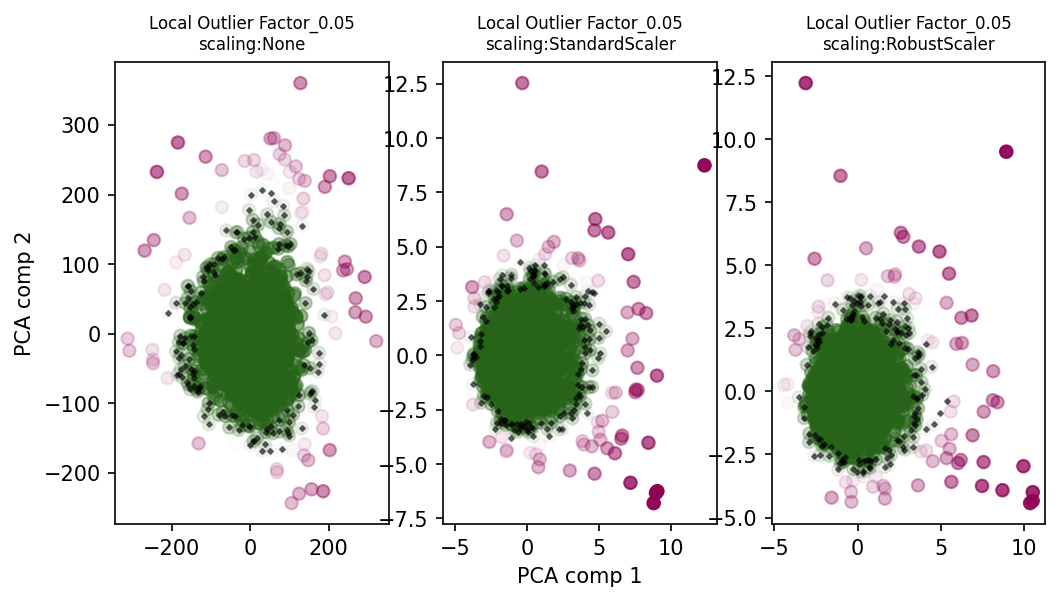

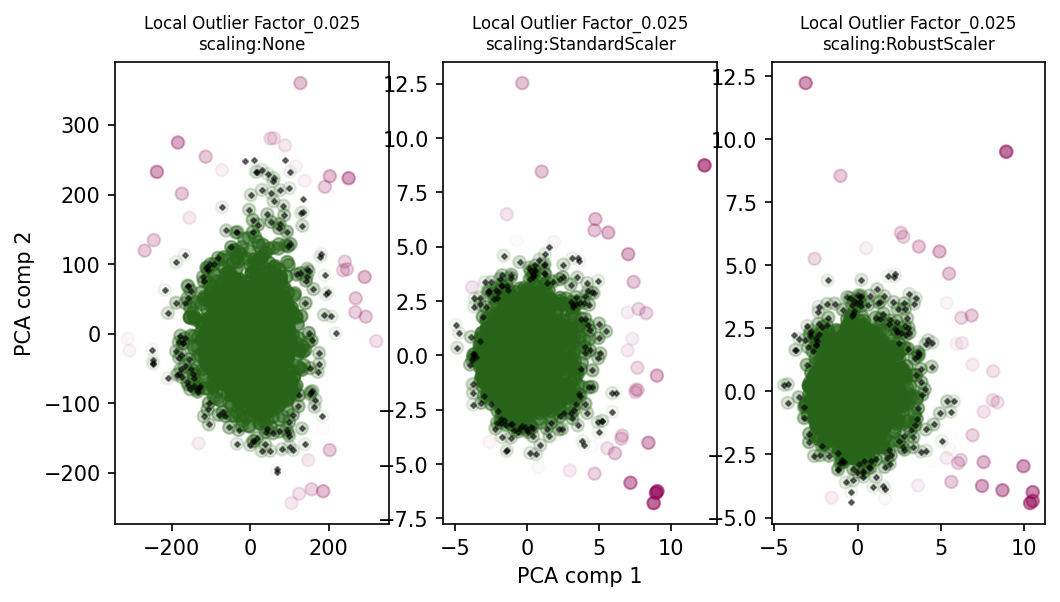

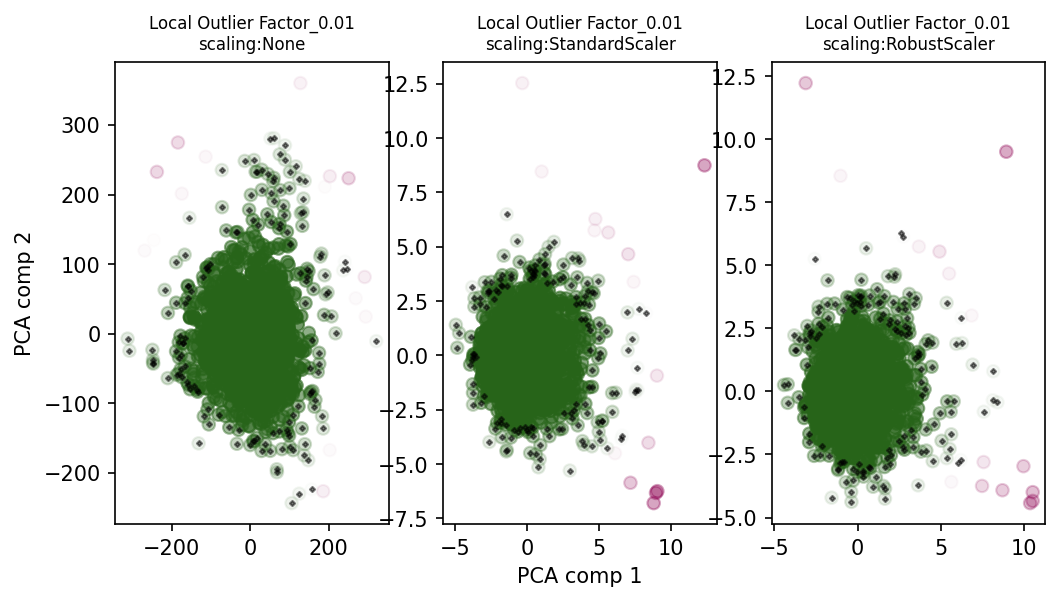

In [207]:

for threshold in ['auto', 0.1, 0.075, 0.05, 0.025, 0.01]:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(8,4), dpi=150)
    iso_forest = IsolationForest(contamination=threshold, random_state=42)
    
    
    for cond in [(None, ax1), (StandardScaler(), ax2), (RobustScaler(), ax3)]:
        X = data.iloc[:,6:-2].copy()
        
        # scale before PCA
        if cond[0]:
            X = cond[0].fit_transform(X)
        
        plot_data = pd.DataFrame(PCA().fit_transform(X)[:,0:2], columns=['pca_1','pca_2'])
        iso_forest.fit(plot_data)
        plot_data['anomaly_score'] = iso_forest.decision_function(plot_data)
        plot_data['outlier'] = iso_forest.predict(plot_data[['pca_1','pca_2']])

        cond[1].scatter(plot_data['pca_1'], plot_data['pca_2'], 
                        c=plot_data['outlier'], cmap='PiYG',
                        alpha=(1/abs(plot_data['anomaly_score']).max())*abs(plot_data['anomaly_score']))   
        
        border = plot_data[
   (plot_data['outlier']==1) &\
   (plot_data['anomaly_score'] < np.percentile(plot_data[plot_data['outlier']==1]['anomaly_score'], 10))
                          ]

        cond[1].scatter(border['pca_1'], border['pca_2'], 
            marker='D', color='k', s=3, alpha=0.5) 
        
        cond[1].set_title(f'Local Outlier Factor_{threshold}\nscaling:{str(cond[0]).replace("()","")}',
                         fontsize=8)
        if cond[1] == ax1:
            cond[1].set_ylabel('PCA comp 2')
        elif cond[1] == ax2:
            cond[1].set_xlabel('PCA comp 1')
        
    plt.savefig(f'graphs/Outlier Detection/PCA/IsoForest_{threshold}.png', bbox_inches='tight')
    plt.show()

### Local Outlier Factor - PCA components

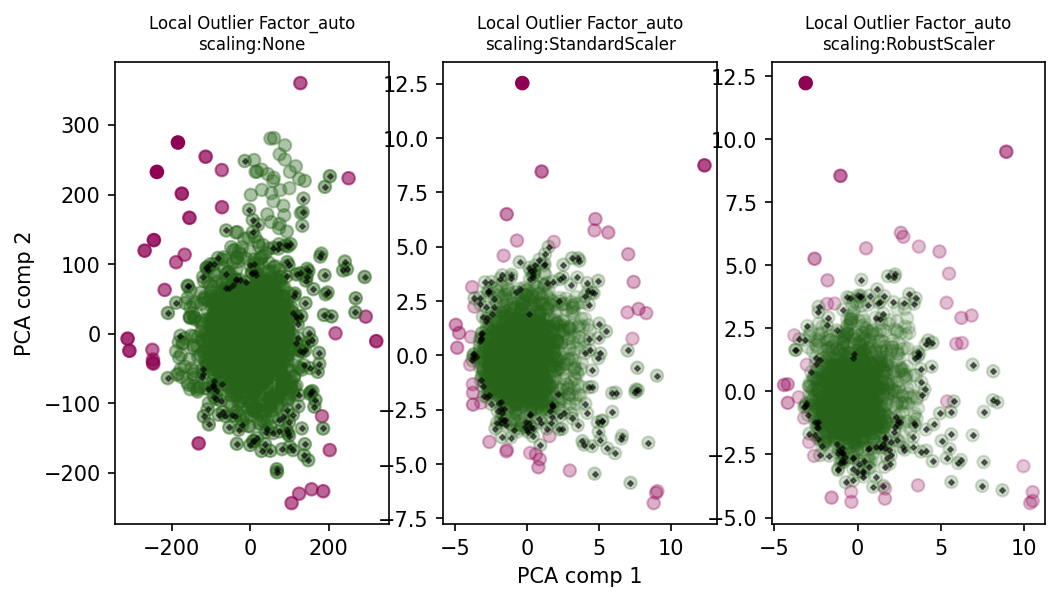

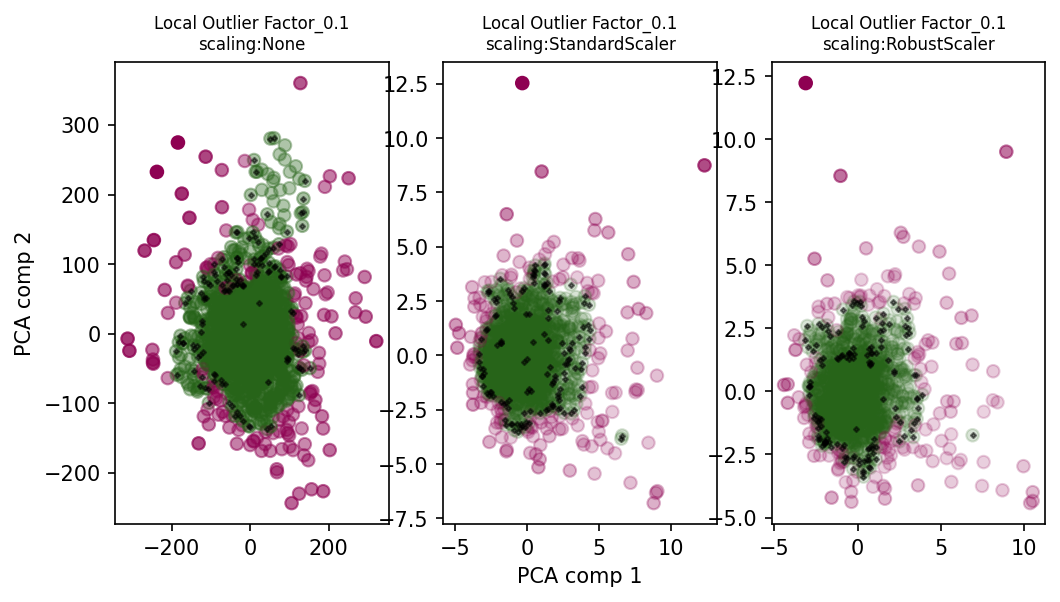

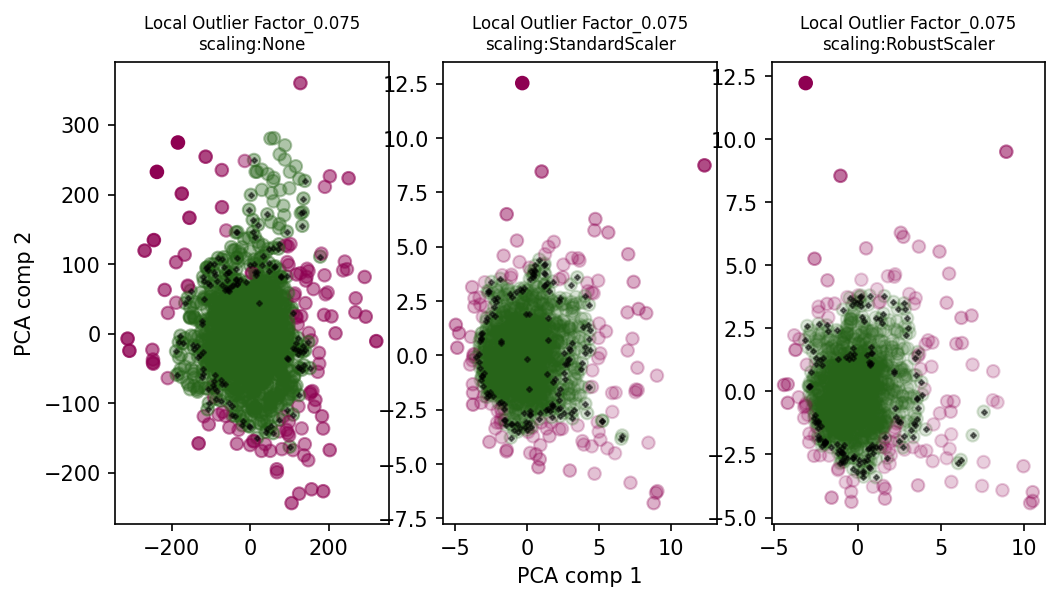

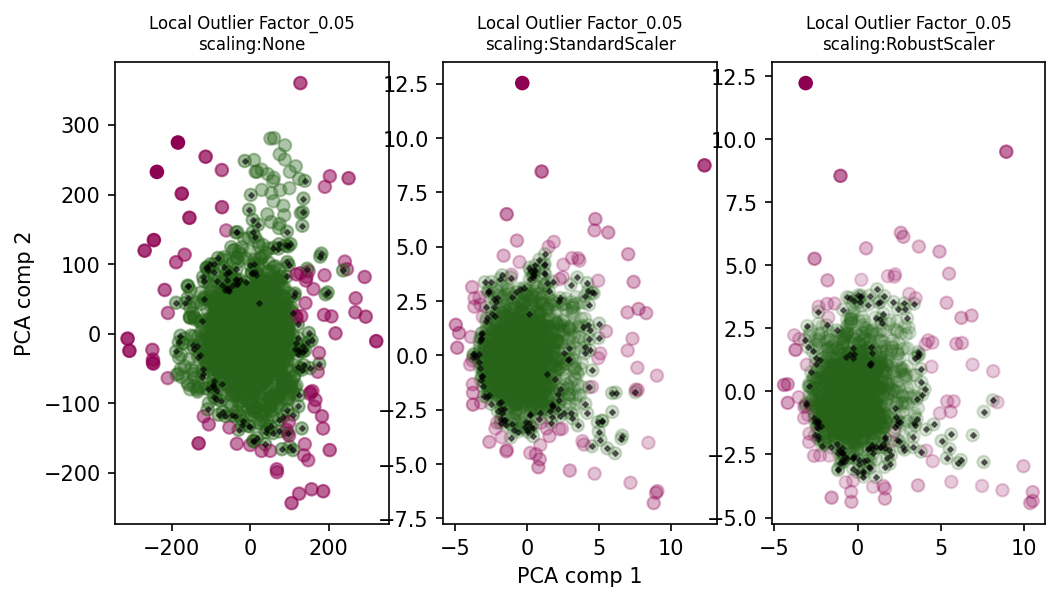

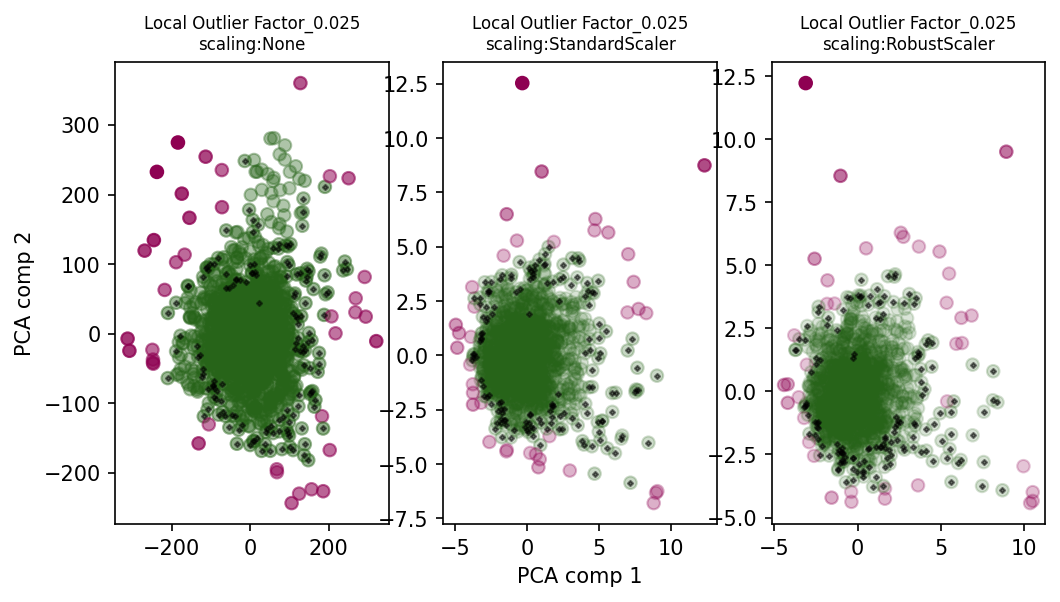

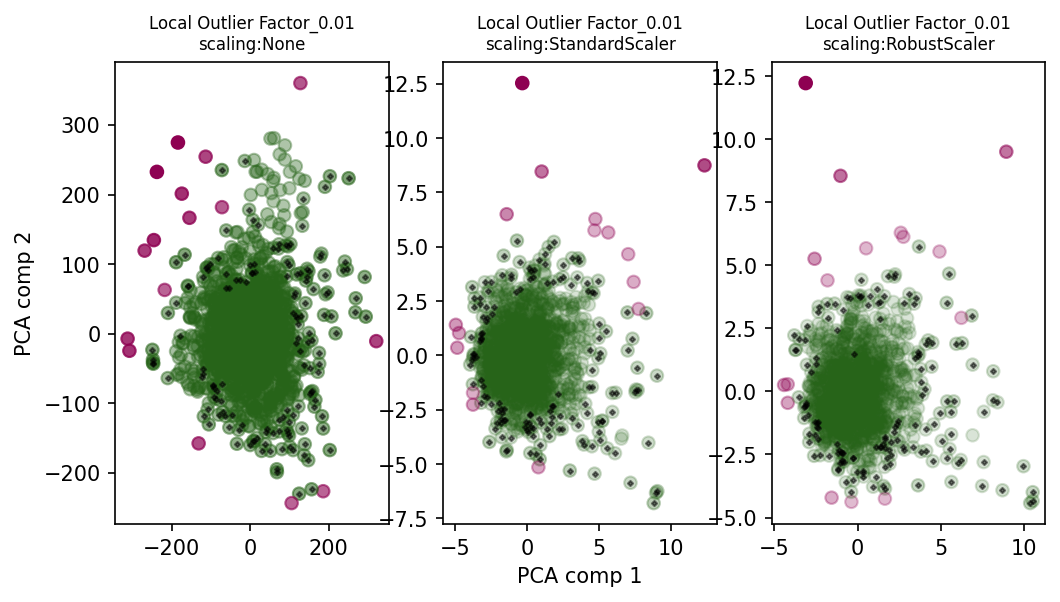

In [203]:

for threshold in ['auto', 0.1, 0.075, 0.05, 0.025, 0.01]:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(8,4), dpi=150)
    lof = LocalOutlierFactor(contamination=threshold, novelty=False)
    
    
    for cond in [(None, ax1), (StandardScaler(), ax2), (RobustScaler(), ax3)]:
        X = data.iloc[:,6:-2].copy()
        
        # scale before PCA
        if cond[0]:
            X = cond[0].fit_transform(X)
        
        plot_data = pd.DataFrame(PCA().fit_transform(X)[:,0:2], columns=['pca_1','pca_2'])
        lof.fit(plot_data)
        plot_data['anomaly_score'] = lof.negative_outlier_factor_
        plot_data['outlier'] = plot_data['anomaly_score'] < lof.offset_

        cond[1].scatter(plot_data['pca_1'], plot_data['pca_2'], 
                        c=plot_data['outlier'], cmap='PiYG_r',
                        alpha=(1/abs(plot_data['anomaly_score']).max())*abs(plot_data['anomaly_score']))   
        
        border = plot_data[
   (plot_data['outlier']==0) &\
   (plot_data['anomaly_score'] < np.percentile(plot_data[plot_data['outlier']==0]['anomaly_score'], 10))
                          ]

        cond[1].scatter(border['pca_1'], border['pca_2'], 
            marker='D', color='k', s=3, alpha=0.5) 
        
        cond[1].set_title(f'Local Outlier Factor_{threshold}\nscaling:{str(cond[0]).replace("()","")}',
                         fontsize=8)
        if cond[1] == ax1:
            cond[1].set_ylabel('PCA comp 2')
        elif cond[1] == ax2:
            cond[1].set_xlabel('PCA comp 1')
        
    plt.savefig(f'graphs/Outlier Detection/PCA/LocalOutlierFactor_{threshold}.png', bbox_inches='tight')
    plt.show()